In [30]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import tqdm as notebook_tqdm
import warnings
import seaborn as sns
import optuna
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_edf,
    plot_slice,
    plot_parallel_coordinate,
)
from optuna.integration import LightGBMPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings('ignore')

In [31]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
# plt.rc('font', family='NanumBarunGothic')
# mac os
fe = fm.FontEntry(
    fname=r'/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'})  # 폰트 설정
plt.rc('font', family='AppleGothic')

In [32]:
# def _first_existing(paths):
#     for p in paths:
#         p = os.path.expanduser(p)
#         if os.path.isfile(p):
#             return p
#     return None
#
# # 1) 대표 경로 후보들(NanumGothic)
# nanum_candidates = [
#     "~/Library/Fonts/NanumGothic.ttf",
#     "/Library/Fonts/NanumGothic.ttf",
#     "/System/Library/Fonts/Supplemental/NanumGothic.ttf"
# ]
#
# font_path = _first_existing(nanum_candidates)
#
# # 2) 시스템 전체 폰트 목록에서 추가 탐색
# if font_path is None:
#     try:
#         system_fonts = fm.findSystemFonts(fontext="ttf")
#         for f in system_fonts:
#             base = os.path.basename(f).lower()
#             if "nanum" in base and "gothic" in base:  # 예: NanumGothic.ttf, NanumGothicBold.ttf ...
#                 font_path = f
#                 break
#     except Exception:
#         pass
#
# # 3) NanumGothic 등록 시도
# registered_name = None
# if font_path and os.path.isfile(font_path):
#     try:
#         fe = fm.FontEntry(fname=font_path, name="NanumGothic")
#         fm.fontManager.ttflist.insert(0, fe)
#         registered_name = "NanumGothic"
#         print(f"[Font] Registered NanumGothic at: {font_path}")
#     except Exception as e:
#         print(f"[Font] Failed to register NanumGothic: {e}")
#
# # 4) RC 설정 (우선순위: NanumGothic -> AppleGothic -> 기본 폰트)
# priority_families = ["NanumGothic", "AppleGothic", "DejaVu Sans"]
# plt.rcParams.update({
#     "font.size": 10,
#     "font.family": priority_families
# })
# plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지
#
# # 확인용 출력
# try:
#     from matplotlib import font_manager as _fm
#     current_font_path = _fm.findfont(_fm.FontProperties(family=priority_families))
#     print(f"[Font] Using: {current_font_path}")
# except Exception:
#     pass


In [33]:
train = pd.read_csv('../03_outlier/train_processed.csv')
test = pd.read_csv('../03_outlier/test_processed.csv')

In [35]:
train.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k_단지분류_아파트_주상복합등등_', 'k_전화번호', 'k_팩스번호', 'k_세대타입_분양형태_', 'k_관리방식',
       'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수', 'k_건설사_시공사_', 'k_시행사',
       'k_사용검사일-사용승인일', 'k_연면적', 'k_주거전용면적', 'k_관리비부과면적', 'k_전용면적별세대현황_60㎡이하_',
       'k_전용면적별세대현황_60㎡~85㎡이하_', 'k_85㎡~135㎡이하', 'k_수정일자', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', 'is_test', '주소', '경도', '위도', '1_bus', '3_bus',
       '5_bus', '10_bus', '1_school', '3_school', '5_school', '10_school',
       'bus_access_score', 'sub_access_score', 'school_access_score', '1_sub',
       '3_sub', '5_sub', '10_sub', '계약연도', '계약월', '구', '동', '아파트_최고층',
       '층_최고층대비비율', '층구간_상대', '구_해당달_거래수', '동_해당달_거래수', '구_직전달까지누적거래수',
       '동_직전달까지누적거래수', '동대구_해당달_비율', '동대구_직전누적_비율', '연식', '연식_bin', '강남여부',
       '브랜드', 'area_bin_in_region', 'target_log_clip'],
      dtype='object')

In [36]:
target_col = 'target_log_clip'

In [37]:
# 범주형 컬럼 자동 탐지 + 명시적 범주형 포함
auto_cats = train.select_dtypes(include=['object', 'category']).columns.tolist()
explicit_cats = ['연식_bin', '층구간_상대', '브랜드', '아파트명', '도로명', '주소', '구', '동', 'area_bin_in_region']
cat_cols = [c for c in (set(auto_cats) | set(explicit_cats)) if c in train.columns]

In [38]:
# Train/Test 합쳐 카테고리 정합
if len(cat_cols) > 0:
    concat = pd.concat([train[cat_cols], test[cat_cols]], axis=0, ignore_index=True)
    for c in cat_cols:
        concat[c] = concat[c].astype('category')
    for c in cat_cols:
        train[c] = pd.Categorical(train[c], categories=concat[c].cat.categories)
        test[c] = pd.Categorical(test[c], categories=concat[c].cat.categories)

In [39]:
# 피처/타깃 분리 (is_test는 정보량이 없으므로 제거)
drop_cols = [target_col]
if 'is_test' in train.columns:
    drop_cols.append('is_test')

In [40]:
X = train.drop(columns=drop_cols)
y = train[target_col].astype(float)
X_test = test.drop(columns=['is_test']) if 'is_test' in test.columns else test.copy()

In [41]:
categorical_feature = cat_cols
print(f"[INFO] 사용 범주형 컬럼: {categorical_feature}")
print(f"[INFO] X.shape={X.shape}, X_test.shape={X_test.shape}")

[INFO] 사용 범주형 컬럼: ['주소', 'k_세대타입_분양형태_', 'k_전화번호', 'k_관리방식', 'k_수정일자', '구', '브랜드', '세대전기계약방법', '경비비관리형태', 'k_난방방식', '동', '도로명', 'area_bin_in_region', 'k_시행사', 'k_사용검사일-사용승인일', '아파트명', 'k_복도유형', '층구간_상대', 'k_단지분류_아파트_주상복합등등_', '청소비관리형태', '연식_bin', 'k_팩스번호', 'k_건설사_시공사_']
[INFO] X.shape=(23610, 67), X_test.shape=(9272, 67)


In [42]:
# 결측치 확인
print("[CHECK] X 결측치 합계:", X.isnull().sum().sum())
print("[CHECK] y 결측치 합계:", y.isnull().sum())
print("[CHECK] X_test 결측치 합계:", X_test.isnull().sum().sum())

[CHECK] X 결측치 합계: 0
[CHECK] y 결측치 합계: 0
[CHECK] X_test 결측치 합계: 144649


In [43]:
kf_opt = KFold(n_splits=5, shuffle=True, random_state=2023)
fold_indices = list(kf_opt.split(X, y))  # 캐싱

# 원 스케일 RMSE로 EarlyStopping/Pruning을 맞추기 위한 custom metric
def feval_orig_rmse(y_true: np.ndarray, y_pred: np.ndarray):
    """
    LightGBM(sklearn API)용 커스텀 평가 함수
    - 입력: y_true, y_pred (둘 다 로그 스케일일 때 원스케일 RMSE 측정)
    - 반환: (메트릭명, 값, is_higher_better)
    """
    # y_true, y_pred 가 로그 스케일로 학습되었다면 원스케일로 복원
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)

    # RMSE 계산
    rmse = np.sqrt(np.mean((y_true_orig - y_pred_orig) ** 2))
    # 낮을수록 좋은 지표이므로 is_higher_better=False
    return "orig_rmse", rmse, False


# Optuna로 LightGBM 하이퍼파라미터 탐색
def objective(trial):
    # 조건/제약 반영된 탐색 공간
    max_depth = trial.suggest_categorical("max_depth", [-1, 6, 8, 10, 12])
    num_leaves_hi = 512 if max_depth == -1 else min(2 ** max_depth, 512)
    params = {
        "objective": "regression",
        "metric": "rmse",  # 내부 기록용으로는 유지하되, ES/Pruning은 custom을 사용
        "verbosity": -1,
        "random_state": 2023,
        "n_estimators": 20000,  # 충분히 크게 두고 ES로 조기 종료
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, num_leaves_hi, log=True),
        "max_depth": max_depth,
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        # 상단 경계 0.95로 조정하여 bagging 활성화 조합만 탐색
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.95),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),  # 최소 1로 보정
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "n_jobs": 1,  # 중첩 병렬화 방지(Optuna가 병렬)
    }

    # 안전망: bagging_fraction<1.0인데 bagging_freq==0이면 최소 1로
    if params["bagging_fraction"] < 0.999 and params["bagging_freq"] == 0:
        params["bagging_freq"] = 1

    rmses = []
    for trn_idx, val_idx in fold_indices:
        X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_trn, y_trn,
            eval_set=[(X_val, y_val)],
            # 원 스케일 RMSE를 사용하여 ES/Pruning을 일치시킴
            eval_metric=feval_orig_rmse,
            categorical_feature=categorical_feature,
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                LightGBMPruningCallback(trial, "orig_rmse", valid_name="valid_0"),
            ],
        )
        val_pred_log = model.predict(X_val, num_iteration=model.best_iteration_)
        rmse = np.sqrt(mean_squared_error(np.expm1(y_val.values), np.expm1(val_pred_log)))
        rmses.append(rmse)

        # 중간값으로도 리포트
        trial.report(float(rmse), step=len(rmses))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(rmses))


In [44]:
print("[Optuna] 탐색을 시작합니다...")
sampler = optuna.samplers.TPESampler(
    seed=2023,                # 재현성
    n_startup_trials=15,      # 초기 탐색
    multivariate=True,        # 다변수 추론
    group=True                # 파라미터 그룹 활용
)
# 빠른 프루닝(초기 수치가 나쁘면 컷), 더 강한 컷을 원하면 n_warmup_steps 조정
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=0)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

# 병렬 트라이얼 수(기본: 물리코어 절반), 너무 크게 잡으면 메모리 압박
n_jobs_optuna = max(1, (os.cpu_count() or 2) // 2)

# 실행
study.optimize(objective, n_trials=80, n_jobs=n_jobs_optuna, show_progress_bar=True)
print(f"[Optuna] Best RMSE(orig): {study.best_value:.5f}")
print("[Optuna] Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

best_params_optuna = {
    "random_state": 2023,
    "n_estimators": 100000,
    "n_jobs": 1,  # 최종 학습은 폴드 병렬화가 아니라 LightGBM 내부 병렬화로 돌리고 싶다면 여기서 조정
}
best_params_optuna.update(study.best_params)

[Optuna] 탐색을 시작합니다...


  0%|          | 0/80 [00:00<?, ?it/s]

[W 2025-09-10 17:36:25,901] The parameter `num_leaves` in Trial#34 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.
[W 2025-09-10 17:36:25,932] The parameter `num_leaves` in Trial#35 is sampled independently using `RandomSampler` instead of `TPESampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported for `multivariate=True`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler` if this independent sampling is intended behavior.
[W 2025-09-10 17:36:32,252] The parameter `num_leaves` in Trial#57 is sampled independently using `R

In [45]:
# K-Fold 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

# 베스트 폴드 단일 모델만 선택
best_model = None
best_fold = None
best_fold_rmse = np.inf
best_iteration = None

# 충분히 큰 반복 + Early Stopping
# Optuna에서 탐색된 하이퍼파라미터 사용
base_params = dict(
    **best_params_optuna
)

oof_pred_log = np.zeros(len(X))
fold_rmses = []

In [46]:
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    print(f"[KFold] Fold {fold}/{n_splits} 학습 중...")
    X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(**base_params)
    model.fit(
        X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    val_pred_log = model.predict(X_val, num_iteration=model.best_iteration_)
    oof_pred_log[val_idx] = val_pred_log

    # 원스케일 RMSE
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val.values), np.expm1(val_pred_log)))
    fold_rmses.append(rmse)
    print(f"[KFold] Fold {fold} RMSE(orig) = {rmse:,.5f}, best_iter = {model.best_iteration_}")

    # 베스트 폴드 갱신
    if rmse < best_fold_rmse:
        best_fold_rmse = rmse
        best_fold = fold
        best_model = model
        best_iteration = model.best_iteration_

[KFold] Fold 1/5 학습 중...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.36284932941027126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36284932941027126
[LightGBM] [Warning] feature_fraction is set=0.8927857828764103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8927857828764103
[LightGBM] [Warning] bagging_fraction is set=0.8445019952754365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8445019952754365
[LightGBM] [Warning] lambda_l2 is set=5.527967353258386e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.527967353258386e-06
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0

In [47]:
# 교차검증 요약
print(f"[KFold] CV RMSE(orig): mean={np.mean(fold_rmses):,.5f}, std={np.std(fold_rmses):,.5f}")
print(f"[KFold] Best fold = {best_fold}, RMSE(orig) = {best_fold_rmse:,.5f}, best_iter = {best_iteration}")

# 테스트 예측: 베스트 폴드 단일 모델만 사용
preds_best_log = best_model.predict(X_test, num_iteration=best_iteration)
preds_best = np.expm1(preds_best_log).astype(np.int64)

[KFold] CV RMSE(orig): mean=6,459.04432, std=441.45646
[KFold] Best fold = 1, RMSE(orig) = 5,866.10524, best_iter = 245
[LightGBM] [Warning] lambda_l1 is set=0.36284932941027126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36284932941027126
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8927857828764103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8927857828764103
[LightGBM] [Warning] bagging_fraction is set=0.8445019952754365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8445019952754365
[LightGBM] [Warning] lambda_l2 is set=5.527967353258386e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.527967353258386e-06


In [48]:
# 저장
sub_path = 'lgbm_kfold_optuna_bestfold.csv'
pd.DataFrame({'target': preds_best}).to_csv(sub_path, index=False)
print(f"[SAVE] {sub_path} 저장 완료")

[SAVE] lgbm_kfold_optuna_bestfold.csv 저장 완료


In [49]:
preds_best

array([161773, 208791, 213488, ...,  93646,  84070,  83549], shape=(9272,))

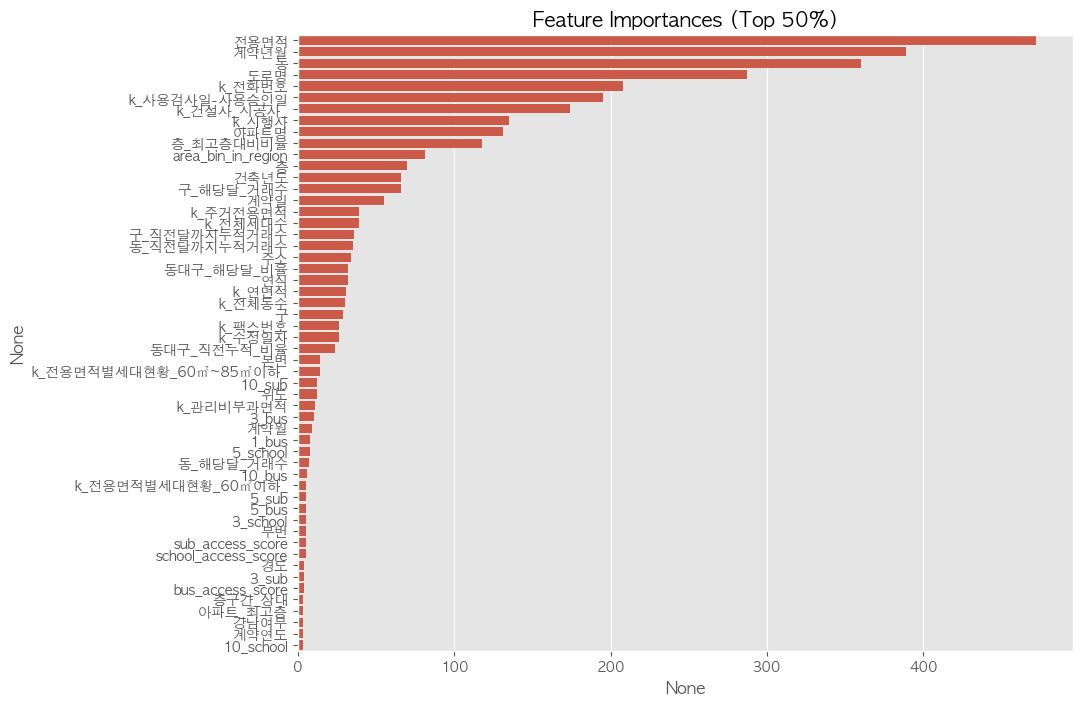

In [50]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X.columns))
importances = importances.sort_values(ascending=False)

# 상위 50%만 선택
top_n = max(1, int(np.ceil(len(importances) * 0.8)))
importances = importances.iloc[:top_n]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Top 50%)")
sns.barplot(x=importances, y=importances.index)
plt.show()

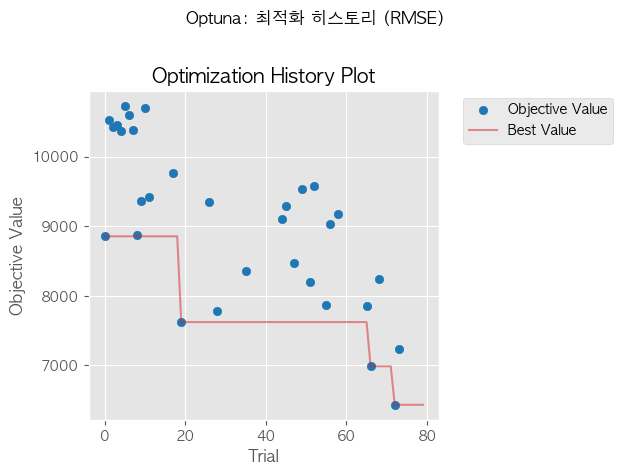

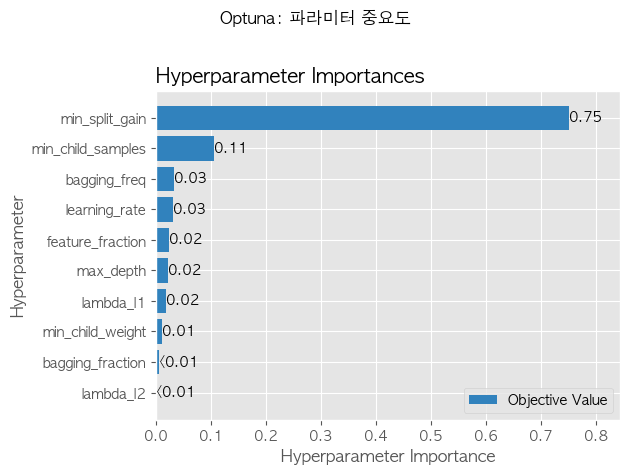

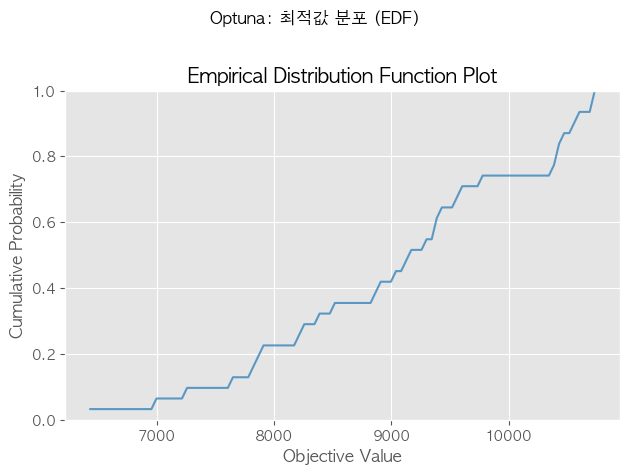

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

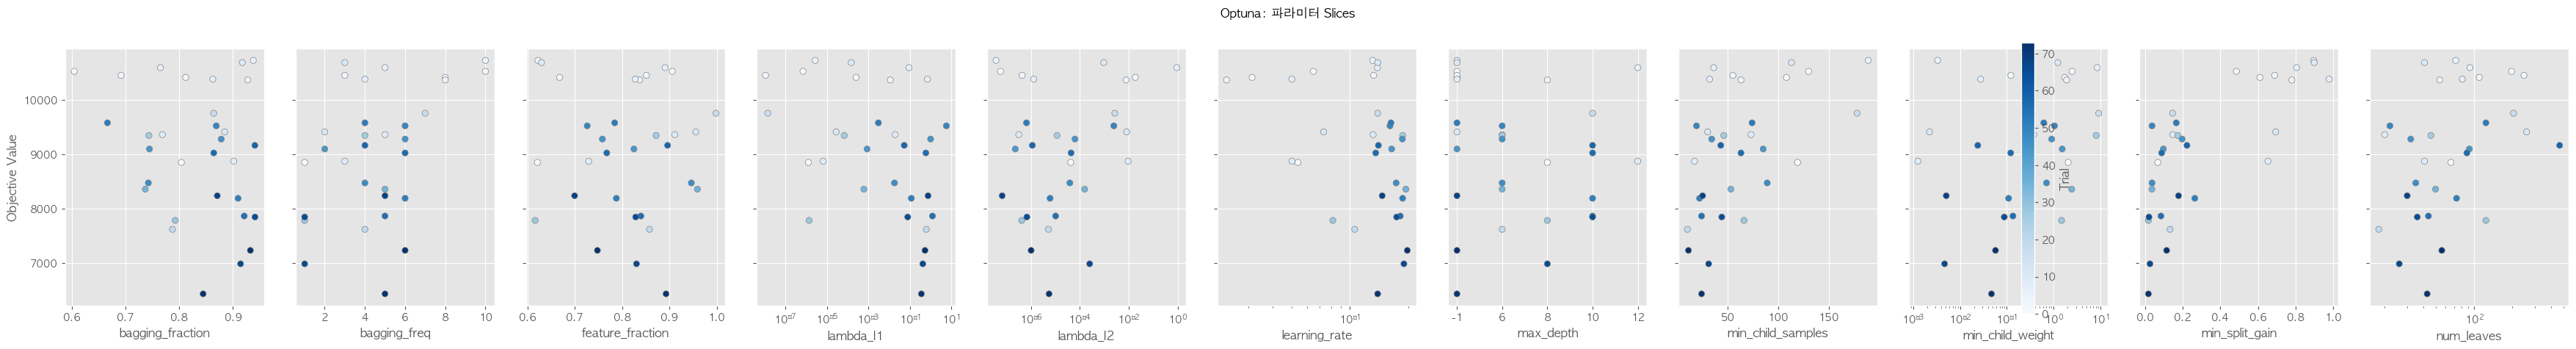

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

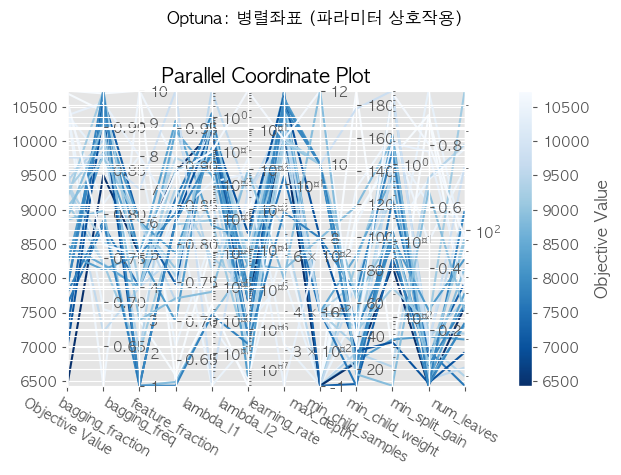

In [54]:
ax = plot_optimization_history(study)
fig = ax.figure if not isinstance(ax, np.ndarray) else ax.ravel()[0].figure
fig.suptitle("Optuna: 최적화 히스토리 (RMSE)")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ax = plot_param_importances(study)
fig = ax.figure if not isinstance(ax, np.ndarray) else ax.ravel()[0].figure
fig.suptitle("Optuna: 파라미터 중요도")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ax = plot_edf(study)
fig = ax.figure if not isinstance(ax, np.ndarray) else ax.ravel()[0].figure
fig.suptitle("Optuna: 최적값 분포 (EDF)")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ax = plot_slice(study)
fig = ax.figure if not isinstance(ax, np.ndarray) else ax.ravel()[0].figure
fig.suptitle("Optuna: 파라미터 Slices")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ax = plot_parallel_coordinate(study)
fig = ax.figure if not isinstance(ax, np.ndarray) else ax.ravel()[0].figure
fig.suptitle("Optuna: 병렬좌표 (파라미터 상호작용)")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
